In [19]:
import numpy as np
from scipy.stats.distributions import norm
import matplotlib.pylab as plt
import matplotlib.cbook
plt.rcParams.update({"axes.grid" : True})
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,matplotlib.cbook.mplDeprecation))
np.set_printoptions(precision=3)

# Téma 2: ACF, PACF, autoregresní modely

## Korelační koeficient (lineární, též Pearsonův)

Mějme dvě náhodné veličiny $X$ a $Y$, obě s kladnými a konečnými druhými momenty - variancemi - $\sigma_X^2$ a $\sigma_Y^2$ a s kovariancí $\operatorname{cov}(X, Y) = \sigma_{XY}$. [Lineární (též Pearsonův) korelační koeficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) definujeme jako

$$
r_{XY} = \frac{\mathbb{E}[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X\sigma_Y} = \frac{\sigma_{XY}}{\sigma_X \sigma_Y}, \qquad r \in [-1, 1].
$$

Lineární korelační koeficient $r_{XY}$ označuje míru lineární závislosti obou veličin. Pokud jsou veličiny $X$ a $Y$ **nezávislé**, pak $r_{XY} = 0$. Pozor, je snadné dokázat, že [**opačné tvrzení neplatí**](https://en.wikipedia.org/wiki/Uncorrelatedness_(probability_theory)#Examples_of_dependence_without_correlation)! Jsou-li veličiny (deterministicky) lineárně závislé, pak $r_{XY} = \pm 1$. To jest, pokud $Y=aX + b$ a $a>0$, je $r_{XY} = 1$, pokud $a<0$, je $r_{XY}=-1$. Pokud není jedna veličina deterministicky lineárně vysvětlována druhou, typicky je-li přítomen aditivní šum, je hodnota koeficientu v intervalu $(-1, 1)$. V každém případě je nutno brát v potaz lineární vztah mezi proměnnými! Více viz obrázek z wikipedie.

![corrcoef](img/corrwiki.png)

**Výběrový korelační koeficient** můžeme spočítat pomocí výběrových variancí $s_x^2, s_y^2>0$ např. podle vzorce

$$
r = r_{xy} = \frac{1}{n-1} \sum_{i=1}^{n} 
\left( \frac{x_i - \bar{x}}{s_x} \right)
\left( \frac{y_i - \bar{y}}{s_y} \right),
$$

kde $\bar{x}, \bar{y}$ jsou průměry a $s_x, s_y$ výběrové směrodatné odchylky příslušných veličin. 

**K zamyšlení**

- jak souvisí korelační koeficient s regresí pomocí přímky?
- dokážeme proložit přímku všemi případy v obrázku výše?
- ve stejném případě - je nějaký vztah mezi korelačním koeficientem a koeficientem determinace v regresi?
- souvisí nějak korelační koeficient s kovariancí? Odpověď je v prvním - definujícím - vztahu.
- víme, že pro dva vektory $x, y$ a úhel $\alpha$ jimi sevřený  platí $\cos \alpha = \frac{x\cdot y}{||x||\cdot||y||} \in [-1, 1]$. $n$-rozměrnou náhodné veličiny mají rovněž interpretaci vektoru. Jaká je souvislost mezi vztahem pro úhel $\cos \alpha$ s korelačním koeficientem? 

## Parciální korelační koeficient

### Motivační říklad

Uvažujme následující data, popisující 3 časové řady (ehm :D) v 7 po sobě jdoucích měsících (od ledna):
- `n_fishes`: počet ryb v rybníku
- `n_swimmers`: počet plavců
- `temperature`: naměřená teplota

Data jsou vyloženě umělá, když se na ně pozorně podíváte, uvidíte i jak vznikla. Naším úkolem je zjistit, jak moc je korelovaný počet plavců s počtem ryb :)

In [20]:
df = pd.DataFrame({'n_fishes': [30, 39, 54, 57, 66, 75, 89],
                   'n_swimmers': [12, 15, 18, 21, 24, 27, 35],
                   'temperature': [10, 13, 16, 19, 22, 25, 30]})
print(df)

   n_fishes  n_swimmers  temperature
0        30          12           10
1        39          15           13
2        54          18           16
3        57          21           19
4        66          24           22
5        75          27           25
6        89          35           30


Nástroj první volby - Peasonův výběrový (lineární) korelační koeficient. Zjistíme si korelační matici:

In [21]:
print(df.corr())

             n_fishes  n_swimmers  temperature
n_fishes     1.000000    0.986265     0.993867
n_swimmers   0.986265    1.000000     0.994248
temperature  0.993867    0.994248     1.000000


Pokud bychom v tuto chvíli chtěli vyvodit nějaké závěry, potom zřejmě čím víc ryb, tím víc plavců. Tato kauzalita nám ale "expertně" nesedí. Zkusme data o rybách a o plavcích očistit od teploty. To uděláme následovně:
1. Sestavíme lineární regresní modely pro páry `n_fishes` - `temperature` a `n_swimmers` - `temperature`. Nezapomeneme na posun (intercept, v `statsmodels` metodou `add_constant()`).
2. Z předchozího bodu dostaneme rezidua regrese, tj. odchylky od regresního modelu (dají se zjistit pohledem do syrových dat ;). Určíme korelační koeficient mezi rezidui prvního a druhého modelu.

In [22]:
import statsmodels.api as sm
model1 = sm.OLS(df.n_fishes, sm.add_constant(df.temperature)).fit()
model2 = sm.OLS(df.n_swimmers, sm.add_constant(df.temperature)).fit()
np.corrcoef(model1.resid, model2.resid)

array([[ 1.   , -0.159],
       [-0.159,  1.   ]])

Pokud bychom chtěli použít nějaký balík do pythonu, můžeme třeba následovně. Všimněte si, že korelační koeficient nám opravdu vyšel správně (viz **r**):

In [23]:
from pingouin import partial_corr
partial_corr(data=df, x='n_fishes', y='n_swimmers', covar=['temperature'], method='pearson')

,n,r,CI95%,p-val
pearson,7,-0.159101,"[-0.86, 0.75]",0.763363


### Teorie

Mějme dvě náhodné veličiny $X$ a $Y$, mezi nimiž existuje nějaká lineární závislost, ovšem obě jsou ovlivněny ještě třetí $n$-rozměrnou náhodnou veličinou (vektorem) $Z$. Pokud chceme nyní měřit korelaci mezi $X$ a $Y$, je potřeba je od vlivu $Z$ očistit. To lze udělat tak, že nalezneme regresní přímky

$$
\begin{aligned}
\hat{X} &= a + b^\intercal Z, \\
\hat{Y} &= c + d^\intercal Z.
\end{aligned}
$$

Veličiny $\hat{X}$ a $\hat{Y}$ jsou tedy nejlepším lineárním přiblížením k veličinám $X$ a $Y$ a současně s tím jsou veličiny $e_X = (X-\hat{X})$ a $e_Y = (Y-\hat{Y})$ očištěny od vlivu $Z$, neboť jde o rezidua, jež $Z$ nevysvětlila. Jejich korelační koeficient nazýváme **parciální korelační koeficient mezi $X$ a $Y$ při daném $Z$**, značíme jej $r_{XY\cdot Z}$ a počítáme podle vztahu

$$
r_{XY\cdot Z} =
\frac
{r_{XY} - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y)}
{\sqrt{
\left[ 1 - \operatorname{cor}(X,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,X) \right]
\left[ 1 - \operatorname{cor}(Y,Z)(\operatorname{cor} Z)^{-1} \operatorname{cor}(Z,Y) \right]
}},
$$

kde $\operatorname{cor}(X, Z)= (r_{X,z_i})$ značí korelační matici pro veličinu $X$ a vektor $Z$ (analogicky pro $Y$ a $Z$) a $\operatorname{cor}(Z)=(r_{z_i,z_j})$ je korelační matice prvků $Z$. Pokud je $Z$ skalární, potom dostaneme mnohem jednodušší výraz

$$
r_{XY\cdot Z} = \frac
{r_{XY} - r_{ZX}r_{ZY}}
{\sqrt{\left(1-r_{ZX}^2\right)\left(1-r_{ZY}^2\right)}}.
$$

Typickým příkladem, kde se nám projeví parciální korelační koeficient, je sezónnost v časové řadě. Parciální korelace bude mít typicky vyšší hodnoty v periodách sezón.

**K zamyšlení**

- jaké hodnoty má parciální korelační koeficient?
- jak vypadají data, pokud je parciální korelační koeficient roven jedné?
- jaké vlastnosti má korelační matice? Jaké hodnoty mají prvky, diagonála, jak je to se symetrií?

## Autokorelace, ACF (autocorrelation function)

Ve statistice autokorelační koeficient označuje lineární (Pearsonovu) korelaci hodnot časové řady v různých časových okamžicích. To umožňuje odhalit opakující se vývoj řady.

> Buď $\{X_t, t=1,2,\ldots\}$ časová řada se střední hodnotou $\mu_t$ a variancí $\sigma_t^2>0$ pro každé $t$. Autokorelační koeficient pro časy $s$ a $t$ je definován jako
>
>$$
R(s,t) = \frac{\mathbb{E}[(X_t-\mu_t)(X_s - \mu_s)]}{\sigma_t\sigma_s}, \qquad R(s,t) \in [-1, 1],
$$
>
> za podmínky, že příslušné střední hodnoty a rozptyly existují a jsou kladné.

Pokud je $\{X_t, t=1,2\ldots\}$ slabě stacionární proces, tedy existují časově invariantní první dva momenty $\mu$ a $\sigma^2$, potom autokorelace závisí pouze na zpoždění mezi $t$ a $s$,

$$
R(s, t) = R(s-t) = R(\tau) = \frac{\mathbb{E}[(X_t-\mu)(X_{t+\tau}-\mu]}{\sigma^2}, \qquad \tau=s-t,
$$

a $R(\tau) = R(-\tau)$.

Výběrový autokorelační koeficient slabě stacionárního procesu se známými $\mu$ a $\sigma^2>0$ a s pozorováními $\{x_1, \ldots, x_n\}$ pro čas $k<n$ spočítáme jako

$$
\widehat{R}(k) = \frac{1}{(n-k)} \sum_{t=1}^{n-k} \frac{(x_t - \mu)(x_{t+k} - \mu)}{\sigma^2}.
$$

Pokud střední hodnotu ani rozptyl neznáme, použijeme jejich výběrové odhady, tj. aritmetický průměr $\bar{x}$ a výběrový rozptyl $s^2$.

## Parciální autokorelační funkce (PACF)

Mějme opět časovou řadu $\{X_t\}$. Parciální autokorelace zpoždění $k \geq 1$, značená $\alpha(k)$, je (auto)korelace mezi $X_t$ a $X_{t+k}$ s odstraněním lineárního vlivu mezilehlých hodnot $X_{t+1},\ldots, X_{t+k-1}$, tedy

$$
\alpha(k) = r_{X_{t+k}X_{t}\cdot \{X_{t+1},\ldots,X_{t+k-1}\}}.
$$

Hodnoty PACF se obvykle odhadují z výběrové autokorelace.

## ACF a PACF & intuice...

Sestavme si nejprve následující tabulku pro zpoždění 2 a třeba časový horizont 100 dat:

|řada v $t+2$ | řada v $t$ | mezilehlá v $t+1$ |
|---|---|---|
|$X_{100}$ | $X_{98}$ | $X_{99}$ |
|$X_{99}$ | $X_{97}$ | $X_{98}$ |
|$X_{98}$ | $X_{96}$ | $X_{97}$ |
|$\vdots$ | $\vdots$ | $\vdots$ |
|$X_{3}$ | $X_{1}$ | $X_{2}$ |

- **ACF** pro zpoždění 2 bere v potaz jen první dva sloupce, mezi nimiž počítá korelační koeficient.
- **PACF** pro zpoždění 2 očišťuje o vliv sloupce třetího: provede regresi 1. sloupce na základě třetího, dále regresi 2. sloupce na základě třetího a spočítá korelační koeficient mezi rezidui obou regresí. (viz příklad s rybami a plavci)

Pokud se bude do aktuálních dat promítat vliv dat předchozích, např. **$X_t$ je nějakým způsobem ovlivněno $X_{t-1}$**, lze očekávat, že (absolutní) hodnoty ACF budou postupně klesat, neboť $X_t$ je přímo ovlivněno $X_{t-1}$, do něhož se zase promítá vliv $X_{t-2}$, jež tedy takto ovlivňuje (v menší míře) i ono $X_t$. Totéž platí pro $X_{t-2}$ atd. Pokud bychom se podívali na hodnoty PACF, pak bychom viděli silnou korelaci mezi $X_t$ a $X_{t-1}$, ale další hodnoty už by byly blízké nule, neboť PACF je od vlivu ostatních hodnot očištěno.

Pokud se do aktuálních dat bude promítat pouze přímý vliv šumu z dat předchozích, tedy **$X_t$ bude ovlivněno přímo šumem $\varepsilon_t$ a dejme tomu ještě $\varepsilon_{t-1}$, nikoliv ovšem skrz $X_{t-1}$**, potom je situace jiná. Tento přímý vliv totiž zajistí, že do $X_t$ se nemají jak zpropagovat jiné, starší veličiny. V ACF tedy budeme čekat pouze vysoké hodnoty u současné a předchozí veličiny, ostatní budou blízké nule. Parciální autokorelace bude k nule klesat, ale nedá se o ní říci něco konkrétnějšího.

A do třetice můžeme mít kombinaci obou případů :-)

V předmětu uvidíme, že první případ je tzv. **autoregresní proces** (AR, autoregressive process), druhý je proces **klouzavých průměrů** (MA, moving average) a třetí **smíšené** ARMA procesy.

### Příklady:

**Gaussovský bílý šum** - časová řada s iid veličinami z $N(0, 1)$:

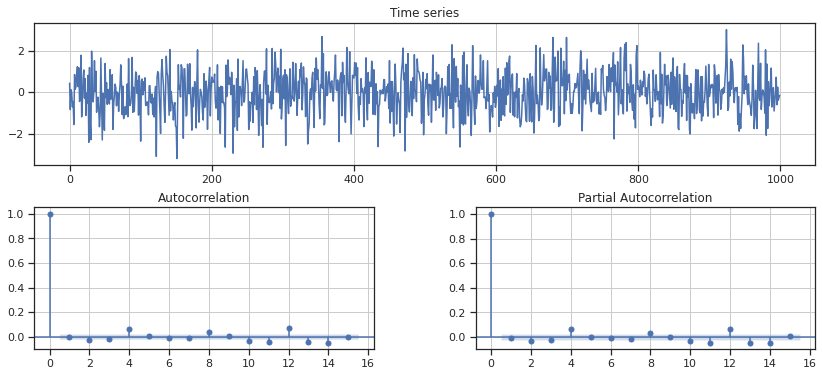

In [40]:
x = norm.rvs(size=1000)
tsplot(x)

**Autoregresní proces 1. řádu** s iid normálním šumem:

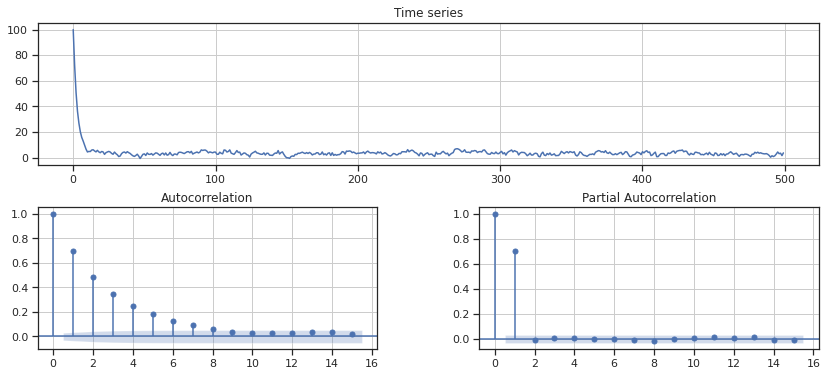

In [26]:
ndat = 500
x = np.zeros(ndat)
x[0] = 100
for t in range(1, ndat):
    x[t] = 1. + 0.7*x[t-1] + norm.rvs()
tsplot(x)

**Sinusovka** vzorkovaná po $\pi/4$ (tj. periodou 8 vzorků) a s iid normálním šumem:

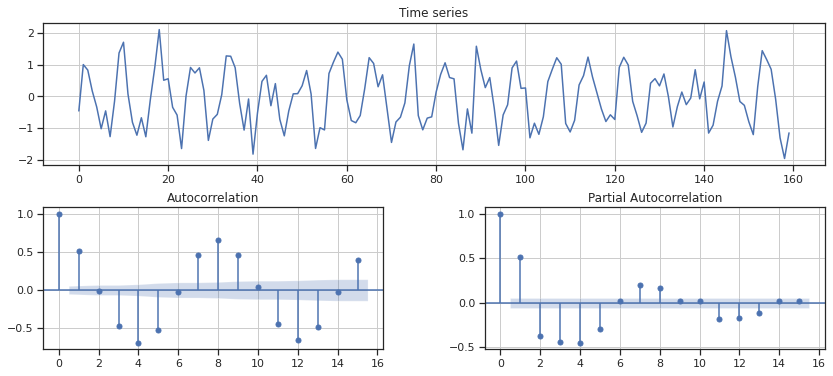

In [42]:
x_i = np.arange(0, 40*np.pi, np.pi/4)
x = np.sin(x_i) + norm.rvs(scale=.5, size=x_i.size)
tsplot(x)

**Autoregresní proces 2. řádu** s iid normálním šumem:

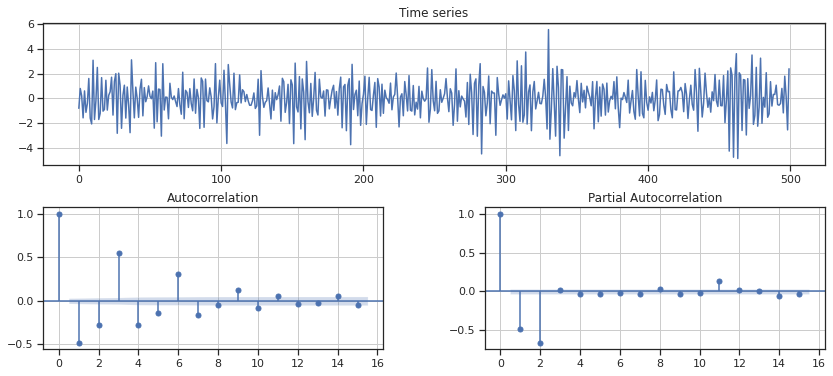

In [46]:
ndat = 500
x = np.zeros(ndat)
x[0] = -.8
x[1] = .8
x[2] = .2
for t in range(3, ndat):
    x[t] = -.8*x[t-1] - 0.6*x[t-2] + norm.rvs()
tsplot(x, lags=15)

**Proces klouzavých průměrů 1. řádu** s iid normálním šumem:

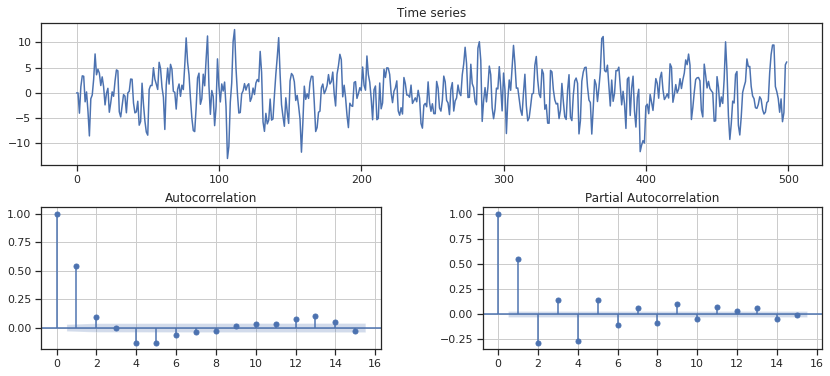

In [51]:
ndat = 500
from scipy.stats import norm, laplace
epsilon = norm.rvs(scale=3, size=ndat)
x = np.zeros(ndat)
mean = 0.
for t in range(2, ndat):
    x[t] = mean + epsilon[t] + .9*epsilon[t-1]
tsplot(x)

## Autoregresní modely AR(p)

Autoregresní modely jsou jedny z nejpopulárnějších modelů v praxi, neboť umožňují popis náhodného procesu na základě jeho předchozích realizací.

> **Definice**
>
> Autoregresním modelem řádu $p$ nazýváme model
>
> $$
\begin{align}
X_t &= c + \phi_1 X_{t-1} + \ldots + \phi_p X_{t-p} + \varepsilon_t \\
&= c + \sum_{\tau=1}^p \phi_\tau X_{t-\tau} + \varepsilon_t \\
&=
\begin{bmatrix}
c \\ \phi_1 \\ \vdots \\ \phi_{p}
\end{bmatrix}^\intercal
\begin{bmatrix}
1 \\ X_{t-1} \\ \vdots \\ X_{t-p}
\end{bmatrix}
+ \varepsilon_t
= \phi^{\intercal} \xi_t + \varepsilon_t = \xi_t^\intercal \phi + \varepsilon_t,
\end{align}
$$
>
> kde $\phi = [c, \ldots, \phi_p]^\intercal$ je vektor regresních koeficientů a $\varepsilon_t$ je bílý šum.

AR modely mohou být prakticky libovolného řádu $p$. Vždy je ale na místě si odpovědět na otázku, zda dávají vyšší řády smysl. Tedy, jak hluboká minulost má determinovat přítomnost.

AR procesy nemusí být slabě stacionární. Podmínkou je, aby kořeny charakteristické rovnice 

$$
1 - \phi_1 z - \phi_2 z^2 - \ldots - \phi_p z^p  = 0
$$

ležely vně jednotkové kružnice, tj. pro každé (komplexní) $z_i\in\mathbb{C}$ platí $|z_i| > 1$. 

> **Poznámka:** Občas je možné se setkat s inverzní charakteristickou rovnicí
>
> $$\zeta^{p} - \phi_1 \zeta^{p-1} - \ldots - \phi_p = 0,$$
>
>která vznikne vynásobením výše uvedené rovnice $z^{-p}$ a substitucí $\zeta = z^{-1}$. Podmínkou stacinarity potom je poloha výsledných kořenů uvnitř jednotkové kružnice. V praxi je důležité najít v nápovědě konkrétního softwaru, kterou rovnici uvažuje.

### Příklad - AR(1): $X_t = c + \phi_1 X_{t-1} + \varepsilon_t$

- $\mathbb{E}[\varepsilon_t]=0$ a $\operatorname{var}\varepsilon_t = \sigma^2$.
- Charakteristická rovnice:

$$
1 - \phi_1 z = 0,
$$

- kořen $z = 1/\phi_1$. Z podmínky pro stacionaritu $|z|>1$ plyne, že proces je (slabě) stacionární pro $|\phi_1|<1$. Potom:

$$
\begin{aligned}
\mathbb{E}[X_t] &= \mathbb{E}[c + \phi_1 X_{t-1} + \varepsilon_t]
                = c + \phi_1 \mathbb{E}[X_{t-1}]
                = \frac{c}{1-\phi_1},\\
\operatorname{var} X_t &= \operatorname{var}(c + \phi_1 X_{t-1} + \varepsilon_t)
                       = \phi_1^2 \operatorname{var} X_{t-1} + \sigma^2
                       = \frac{\sigma^2}{1-\phi_1^2},
\end{aligned}
$$

kde jsme využili tyto vlastnosti:
 - stacionaritu, 
 - $\mathbb{E}[X_{t-1}] = \mathbb{E}[X_t]$,
 - $\operatorname{var}X_{t-1}=\operatorname{var}X_{t}$.

### Odhad parametrů metodou nejmenších čtverců

Řekněme, že máme časovou řadu o 100 realizacích $x_1, \ldots, x_{100}$, kterou chceme popisovat modelem AR(1) ve tvaru

$$
X_t = c + \phi_1 X_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2).
$$

Budiž naším cílem odhadnout regresní koeficienty $c$ a $\phi_1$. K tomu můžeme použít [metodu nejmenších čtverců](https://en.wikipedia.org/wiki/Ordinary_least_squares), kterou již známe z BI-PST, BI-VZD a jiných předmětů. Označme $X$ návrhovou matici, $Y$ vektor měření a $\epsilon$ vektor šumových složek ve tvarech

$$
X =
\begin{bmatrix}
1 & x_{99} \\
1 & x_{98} \\
\vdots & \vdots \\
1 & x_{1}
\end{bmatrix},
\qquad
Y =
\begin{bmatrix}
x_{100} \\ x_{99} \\ \vdots \\ x_{2}
\end{bmatrix}, 
\qquad
\epsilon =
\begin{bmatrix}
\varepsilon_{100} \\ \varepsilon_{99} \\ \vdots \\ \varepsilon_{2}
\end{bmatrix}.
$$

Potom můžeme zapsat

$$
Y = X\phi + \epsilon
$$

a odhadem vektoru $\phi$ metodou nejmenších čtverců je vektor

$$
\hat{\phi} = (X^\intercal X)^{-1} X^\intercal Y.
$$

Za povšimnutí rozhodně stojí, od kterého okamžiku $t$ můžeme začít řádky návrhové matice sestavovat a které pozorování $y_t$ může jako první vstoupit do vektoru $Y$. Zkuste si zapsat matici $X$ a vektor $Y$ pro AR(3).

### Odhad řádu AR modelu

- ACF: postupně klesá k nule, popř. klesá shora i zdola
- PACF : vrcholy do hodnoty řádu modelu, pak jdou strmě k nule

Střední hodnota: 0.500
Variance: 2.778 (std: 1.667)


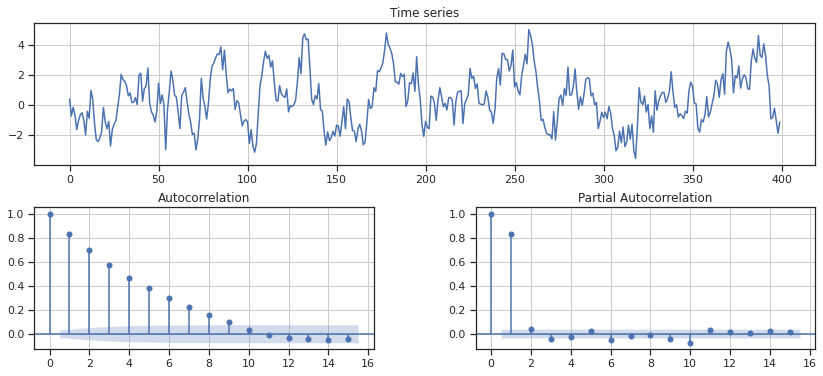

In [53]:
ndat = 400
x = np.zeros(ndat)
x[0] = 0.4
sigma = 1
c = 0.1
phi = [.8]
c_phi = np.insert(phi, 0, c)
for i in range(1, ndat):
    x[i] = np.dot(c_phi, [1, x[i-1]]) + norm.rvs(scale=sigma)
tsplot(x)
EX = c/(1-phi[0])
varX = sigma**2 / (1-phi[0]**2)
print(f'Střední hodnota: {EX:.3f}')
print(f'Variance: {varX:.3f} (std: {np.sqrt(varX):.3f})')

Zdá se, že byl identifikován AR(1). To znamená, že bychom čekali celkem lineární závislost $X_t$ a $X_{t-1}$, což můžeme ověřit obrázkem. Ale pozor, ACF je poměrně vysoká i pro další zpoždění, čili scatterplot nám vlastně tak úplně nepomáhá. Zkusme ostatně měnit `lag' níže...

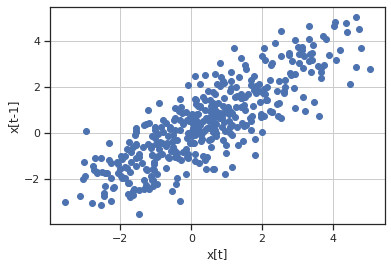

In [54]:
lag = 1
plt.scatter(x[lag:], x[:-lag])
plt.xlabel('x[t]')
plt.ylabel('x[t-1]')
plt.show()

### Příklad - AR(2)

Zkusíme si nasimulovat proces AR(2) a experimentálně studovat jeho vlastnosti. Zajímavé by bylo vysledovat, jak se mění v závislosti na hodnotách $c, \phi_1$ a $\phi_2$. V tomto notebooku budeme používat třídu [AutoReg](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html).

Nejprve si nějaká data nasimulujeme a pokusíme se povšimnout si jejich vlastností:

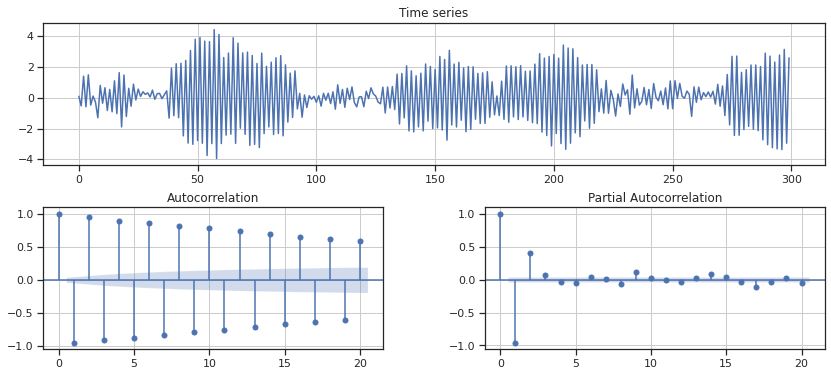

In [91]:
ndat = 300
x = np.zeros(ndat)
x[0] = 0.1
x[1] = -0.1
sigma = .5
c = 0.1
phi = [-.6, .4]
c_phi = np.insert(phi, 0, c)
for i in range(1, ndat):
    x[i] = np.dot(c_phi, [1, x[i-1], x[i-2]]) + norm.rvs(scale=sigma)
tsplot(x, lags=20)

ACF nám (v absolutní) hodnotě plynule klesá k nule, PACF indikuje dvě výrazná zpoždění (lagy).

Sestavíme model a odhadneme regresní koeficienty:

In [92]:
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(x, lags = 2, trend='c').fit()
b = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  300
Model:                     AutoReg(2)   Log Likelihood                -198.768
Method:               Conditional MLE   S.D. of innovations              0.471
Date:                Fri, 23 Sep 2022   AIC                             -1.477
Time:                        17:12:53   BIC                             -1.427
Sample:                             2   HQIC                            -1.457
                                  300                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0930      0.029      3.251      0.001       0.037       0.149
y.L1          -0.5585      0.052    -10.645      0.000      -0.661      -0.456
y.L2           0.4232      0.053      8.030      0.0

Ve výpisu vidíme několik více či méně užitečných údajů. Specificky, v první tabulce:
- `Log Likelihood` - logaritmus věrohodnosti (vzpomeňte na BI-PST a metodu max. věrohodnosti), neboli jaká je hodnota hustota pravděpodobnosti dat při daných odhadech. Čím větší, tím lépe (ehm).
- `S.D. of Innovations` - odhadnutá směrodatná odchylka šumu.
- `AIC, BIC, HQIC` - informační kritéria (probereme později). Čím méně, tím lépe (ehm).

V druhé tabulce máme odhady (`intercept` = posun, tedy konstanta $c$), `y.L1` a `y.L2` jsou příslušné koeficienty pro lag 1 a 2. Vidíme zejména hodnoty odhadu, testovou p-hodnotu pro hypotézu, že příslušný koeficient je roven 0 a intervaly spolehlivosti.

Třetí tabulka popisuje kořeny char. polynomu - reálnou a imaginární část, modulus (zde nás zajímá vztah k jednotkové kružnici) a frekvence. Pomocí těchto údajů dokážeme sestavit tvar kořenu v algebraickém i exponenciálním tvaru.

Můžeme i cvičně ověřit platnost hodnot kořenů charakteristické rovnice:

In [93]:
import sympy
from sympy.solvers import solve

print("Odhadnuté koeficienty: ", b)
z = sympy.Symbol('z')
roots = np.array(solve(1 - b[1]*z - b[2]*z**2, z)).astype(np.float64)
print("Kořeny char. rovnice: ", roots)

Odhadnuté koeficienty:  [ 0.093 -0.558  0.423]
Kořeny char. rovnice:  [-1.013  2.333]


Statsmodels umí provádět i predikce, při nichž využívá dostupná data resp. existující predikce, jde-li o forecasting:

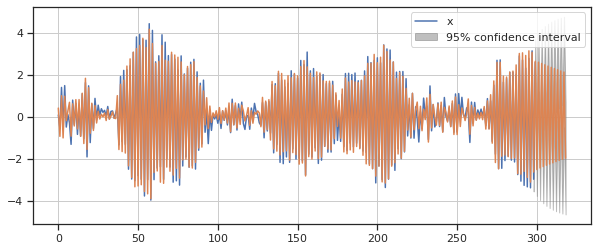

In [94]:
pred_from = 0 #ndat - 100
fcast_horizon = 20
fig = plt.figure(figsize=(10,4))
plt.plot(x[pred_from:], label='x')
res.plot_predict(pred_from, ndat+fcast_horizon, fig=fig)
plt.show()

K nafitovanému modelu můžeme provést některé grafické analýzy. Namátkou by nás mohlo zajímat:
- vývoj (standardizovaných) reziduí - vidíme nějaký "modelovatelný" vývoj?
- histogram (standardizovaných) reziduí, jádrový odhad hustoty (KDE) těchto reziduí a porovnání s hustotou normálního rozdělení.
- [Q-Q plot](https://en.wikipedia.org/wiki/Q-Q_plot): kvantily standardizovaných reziduí versus kvantily N(0, 1). Jde o body na diagonále?
- ACF ("korelogram") - je v reziduích nějaká zbývající korelace, která by mohla jít postihnout lepším modelem?

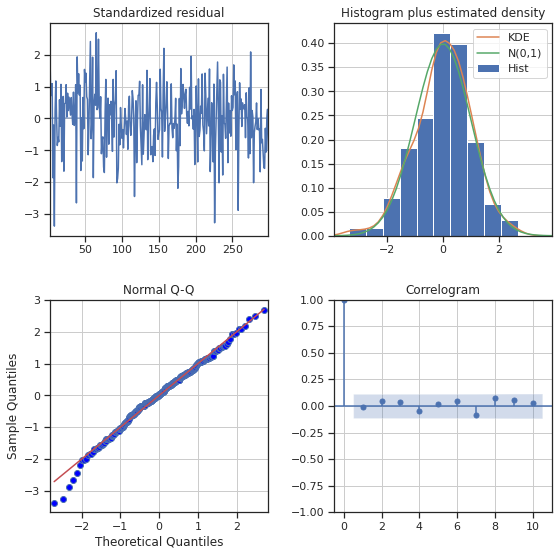

In [95]:
res.plot_diagnostics(figsize=(9,9))
plt.show()

Další analýzu modelu by nám poskytla např. metoda `diagnostic_summary()`, ale tu necháme na jindy.